In [2]:
# when ran on colab
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379413 sha256=f7a0c745aedfb54528d540583533ed0aaf302a97dfef99f4dcf800897c0b1b47
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [2]:
import gymnasium as gym # type: ignore
import numpy as np # type: ignore
from collections import deque
import random
import torch # type: ignore
import torch.nn as nn # type: ignore
import torch.optim as optim # type: ignore
import torch.nn.functional as F # type: ignore
import pickle
import time

import matplotlib.pyplot as plt # type: ignore
import cv2 # type: ignore

from collections import deque, namedtuple
import imageio # type: ignore


torch.backends.cudnn.benchmark = True




BATCH_SIZE = 2048


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")



## pre-processing




In [3]:

def preprocess(obs):
    gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(gray, (84, 84))
    return resized.astype(np.float32) / 255.0

class frame_stacker:
    def __init__(self, k):
        self.k = k
        self.frames = deque([], maxlen=k)

    def reset(self, obs):
        pre = preprocess(obs)
        for _ in range(self.k):
            self.frames.append(pre)
        return np.stack(self.frames, axis=0)

    def step(self, obs):
        self.frames.append(preprocess(obs))
        return np.stack(self.frames, axis=0)


class actor_critic(nn.Module):

    def __init__(self, action_dim):

        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(4, 32, 8, 4), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2), nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1), nn.ReLU()
        )

        self.fc = nn.Sequential(nn.Linear(64 * 7 * 7, 256), nn.ReLU())
        self.mu = nn.Linear(256, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))
        self.value = nn.Linear(256, 1)

    def forward(self, x):

        x = self.conv(x).view(x.size(0), -1)
        x = self.fc(x)
        return x

    def act(self, state):
        
        x = self.forward(state)
        mu = self.mu(x)
        std = self.log_std.exp()
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        return action, dist.log_prob(action).sum(1), dist

    def evaluate(self, states, actions):
        x = self.forward(states)
        mu = self.mu(x)
        std = self.log_std.exp()
        dist = torch.distributions.Normal(mu, std)
        log_probs = dist.log_prob(actions).sum(1, keepdim=True)
        entropy = dist.entropy().sum(1, keepdim=True)
        value = self.value(x)
        return log_probs, entropy, value



## agent defining

In [4]:

class ppo_agent:
    def __init__(self, env):
        self.env = env
        self.action_dim = env.action_space.shape[0]
        self.policy = actor_critic(self.action_dim).to(DEVICE)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=1e-4)

    def collect_trajectories(self, batch_size):

        memory = []
        fs = frame_stacker(4)
        obs, info = self.env.reset()
        state = fs.reset(obs)
        done = False
        score = 0

        while len(memory) < batch_size:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                action, log_prob, _ = self.policy.act(state_tensor)

            action_np = action.cpu().numpy()[0]
            next_obs, reward, terminated, truncated, info = self.env.step(action_np)
            done = terminated or truncated
            next_state = fs.step(next_obs)

            memory.append((state, action_np, reward, log_prob.item(), done))
            state = next_state
            score += reward

            if done:
                obs, info = self.env.reset()
                state = fs.reset(obs)
                done = False

        return self.process_memory(memory), score

    def process_memory(self, memory):
        states, actions, rewards, log_probs, dones = zip(*memory)
        states = torch.FloatTensor(np.array(states)).to(DEVICE)
        actions = torch.FloatTensor(np.array(actions)).to(DEVICE)
        log_probs = torch.FloatTensor(log_probs).unsqueeze(1).to(DEVICE)

        returns, advantages = [], []

        running_return, running_adv, prev_value = 0, 0, 0

        with torch.no_grad():
            
            for t in reversed(range(len(rewards))):
                reward, done = rewards[t], dones[t]
                mask = 1 - int(done)
                value = self.policy.evaluate(states[t].unsqueeze(0), actions[t].unsqueeze(0))[2].item()
                delta = reward + 0.99 * prev_value * mask - value
                running_adv = delta + 0.99 * 0.95 * running_adv * mask
                running_return = reward + 0.99 * running_return * mask
                advantages.insert(0, running_adv)
                returns.insert(0, running_return)
                prev_value = value

        return states, actions, log_probs, torch.FloatTensor(returns).unsqueeze(1).to(DEVICE), torch.FloatTensor(advantages).unsqueeze(1).to(DEVICE)

    def update(self, trajectories):
        states, actions, old_log_probs, returns, advantages = trajectories
        for i in range(4):
            log_probs, entropy, values = self.policy.evaluate(states, actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - 0.2, 1 + 0.2) * advantages
            loss = -torch.min(surr1, surr2).mean() + 0.5 * (returns - values).pow(2).mean() - 0.01 * entropy.mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def train(self, episodes=1000):
        reward_log = []
        best_reward = 0.00
        for ep in range(episodes):
            traj, score = self.collect_trajectories(BATCH_SIZE)
            self.update(traj)
            reward_log.append(score)
            print(f"Episode {ep+1} | Reward: {score:.2f} | timestamp: {time.strftime('%H:%M:%S')}")
            if score > best_reward:
                best_reward = score
                torch.save(self.policy.state_dict(), "ppo.pt")
        return reward_log




## training the agent

Episode 1 | Reward: -110.71 | timestamp: 00:44:17
Episode 2 | Reward: -104.17 | timestamp: 00:44:40
Episode 3 | Reward: -105.03 | timestamp: 00:45:05
Episode 4 | Reward: -115.88 | timestamp: 00:45:27
Episode 5 | Reward: -116.49 | timestamp: 00:45:51
Episode 6 | Reward: -112.85 | timestamp: 00:46:15
Episode 7 | Reward: -111.40 | timestamp: 00:46:39
Episode 8 | Reward: -109.02 | timestamp: 00:47:02
Episode 9 | Reward: -110.48 | timestamp: 00:47:26
Episode 10 | Reward: -107.25 | timestamp: 00:47:50
Episode 11 | Reward: -108.64 | timestamp: 00:48:13
Episode 12 | Reward: -118.70 | timestamp: 00:48:37
Episode 13 | Reward: -134.38 | timestamp: 00:49:01
Episode 14 | Reward: -125.66 | timestamp: 00:49:24
Episode 15 | Reward: -145.76 | timestamp: 00:49:47
Episode 16 | Reward: -135.60 | timestamp: 00:50:10
Episode 17 | Reward: -135.47 | timestamp: 00:50:33
Episode 18 | Reward: -143.65 | timestamp: 00:50:55
Episode 19 | Reward: -138.03 | timestamp: 00:51:18
Episode 20 | Reward: -140.60 | timestamp

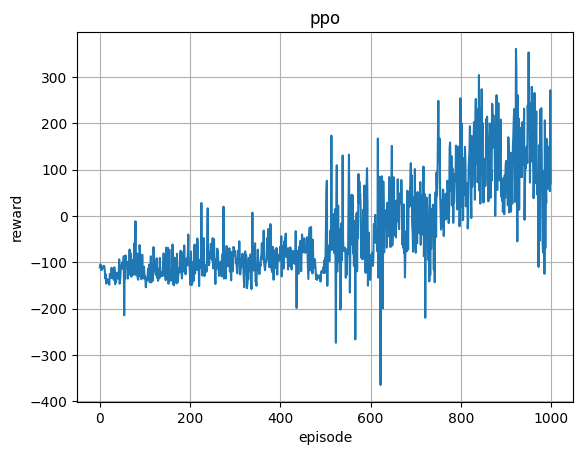

In [4]:
env = gym.make("CarRacing-v3", render_mode=None)
agent = ppo_agent(env)
rewards = agent.train()

plt.plot(rewards)
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("ppo")
plt.grid(True)
plt.show()


## evaluating the agent

In [13]:
def evaluate_agent( model_path):

    env = gym.make("CarRacing-v3", render_mode='rgb_array')
    fs = frame_stacker(4)


    action_dim = env.action_space.shape[0]
    policy = actor_critic(action_dim).to(DEVICE)
    policy.load_state_dict(torch.load(model_path, map_location=DEVICE))
    policy.eval()

    episode_rewards = []

    for ep in range(10):

        obs, info = env.reset()
        state = fs.reset(obs)
        done = False
        total_reward = 0

        while not done:

            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                mu = policy.mu(policy.forward(state_tensor))
            action = mu.cpu().numpy()[0]

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = fs.step(next_obs)
            total_reward += reward

        episode_rewards.append(total_reward)
        print(f"episode {ep+1}: reward = {total_reward:.2f}")

    env.close()

    print(f'avg reward : {sum(episode_rewards)/10}')

    plot_rewards(episode_rewards, label="ppo evaluation")






def plot_rewards(rewards, label):
    
    plt.figure(figsize=(10, 4))
    plt.plot(rewards, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode Reward Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()



/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_55373/1800776281.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(model_path

episode 1: reward = -74.44
episode 2: reward = -67.86
episode 3: reward = -70.20
episode 4: reward = -71.43
episode 5: reward = -68.97
episode 6: reward = -67.39
episode 7: reward = -67.39
episode 8: reward = -56.04
episode 9: reward = -73.13
episode 10: reward = -68.31
avg reward : -68.51615538452235


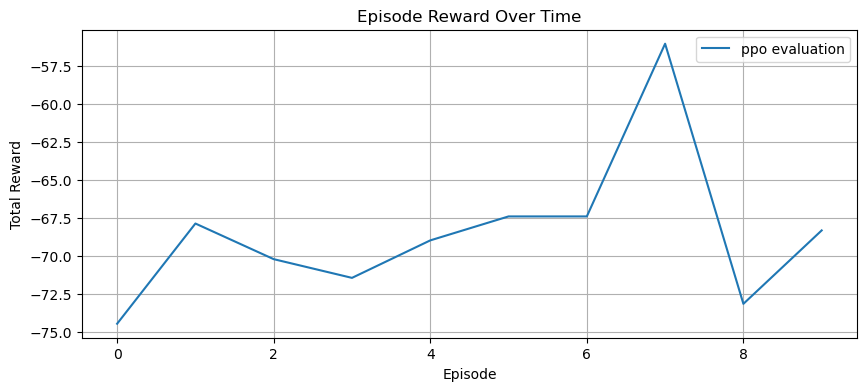

In [14]:

evaluate_agent( "ppo.pt")

## saving a single episode

In [13]:


def record_single_run_video(model_path="ppo.pt", filename="ppo.mp4"):


    env = gym.make("CarRacing-v3", render_mode="rgb_array")
    fs = frame_stacker(4)
    obs, _ = env.reset()
    state = fs.reset(obs)

    agent = ppo_agent(env)
    agent.policy.load_state_dict(torch.load(model_path, map_location=DEVICE))
    agent.policy.eval()


    frames = []
    done = False
    while not done:
        frame = env.render()
        frames.append(frame)

        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            action, _, _ = agent.policy.act(state_tensor)

        obs, reward, terminated, truncated, info = env.step(action.cpu().numpy()[0])
        done = terminated or truncated
        state = fs.step(obs)

    env.close()


    imageio.mimsave(filename, frames, fps=30)



In [14]:
record_single_run_video("ppo.pt")


/var/folders/jp/2bd2v8t94j7b19234wnwph_h0000gn/T/ipykernel_40750/3802844013.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy.load_state_dict(torch.load(mode